# Gurobi(Python调用)求解VRPTW问题
作者：yrf990409

软件：VS Code, Python 3.9, Gurobi 9.5

致谢：Gurobi(中国), 运小筹微信公众号

参考：https://doi.org/10.1137/1.9780898718515.ch7; https://mp.weixin.qq.com/s/tF-ayzjpZfuZvelvItuecw


In [1]:
# 导入所需包
import gurobipy as gp
import numpy as np
import math
import copy
import matplotlib.pyplot as plt

## 数据处理


In [2]:
# 导入数据
np.set_printoptions(suppress=True)    # 取消numpy打印的科学计数法
data = np.loadtxt('./Data/c101.csv',  # 相对路径下的csv文件，可替换成你的数据
                  dtype=None,         # 数据类型默认
                  encoding='UTF-8',   # 注意此文件为UTF-8格式且取消BOM
                  delimiter=',')      # 分隔符

'''
关于Slomon数据的每列数据的定义,可查看下列代码
也可以访问 https://www.sintef.no/projectweb/top/vrptw/100-customers/
下载原始txt数据
原始数据仅转换成CSV格式,并未增删,因此需要进一步处理
'''
# 数据提取，处理
# 数据切片
x_coord  = np.append(data[:,1],data[0,1])   # 横坐标
y_coord  = np.append(data[:,2],data[0,2])   # 纵坐标
demands  = np.append(data[:,3],data[0,3])   # 需求
ready_t  = np.append(data[:,4],data[0,4])   # 左时间窗
due_t    = np.append(data[:,5],data[0,5])   # 右时间窗
serve_t  = np.append(data[:,6],data[0,6])   # 服务时长

# 车辆数据
# 车辆数据的大小请查阅Solomon原始txt文件中的定义
v_cap = 200 # solomon数据集中 1系列容量为200 2系列容量为1000
v_num = 25

# 定义集合
V = [(i) for i in range(x_coord.size)] 
N = V[1:-1]
A = [(i,j) for i in V for j in V]
K = [(k) for k in range(v_num)]
# print(V) # 0,1,...,101
# print(N) # 1,2,...,100
# print(A) # (0,0)至(101,101)
# print(K) # 0,1,...,24

# 定义时间上下界
E = float(ready_t[0])
L = float(due_t[0])

# 定义大M
M = 10000

# 定义容量
C = v_cap

# 距离矩阵计算(字典)
# 欧式距离
c = {(i,j):
    math.sqrt((x_coord[i]-x_coord[j])**2 + 
              (y_coord[i]-y_coord[j])**2)
    for i in V
    for j in V}
# print(len(c)) # 102*102

# 行驶时间矩阵
t = copy.deepcopy(c)

# 左时间窗
a = {(i):ready_t[i] for i in V}

# 右时间窗
b = {(i):due_t[i] for i in V}

# 服务时长
s = {(i):serve_t[i] for i in V}

# 客户需求
d = {(i):demands[i] for i in N}



## 定义函数

In [3]:
def DeltaPlus(i,V):
    delta_plus = copy.deepcopy(V) # 深拷贝，否则对V直接操作
    delta_plus.remove(0) # i之后访问的点不能是出发点
    if i != 0:
        delta_plus.remove(i) # i之后访问的点不能是自身
    return delta_plus

def DeltaMinus(i,V):
    delta_minus = copy.deepcopy(V) # 深拷贝，否则对V直接操作
    if i != delta_minus[-1]:
        delta_minus.remove(i) # 到达i的点不能是自身
        del delta_minus[-1]   # 到达i的点不能是返回点
    else:
        del delta_minus[-1]   # 到达i的点不能是返回点或自身
    return delta_minus


## 建模
### 实例化模型

In [4]:
m = gp.Model()

### 创建决策变量
模型的决策变量如下：

- $x_{ijk},\,\, \forall (i,j)\in A,k\in K$为0-1决策变量，即车辆$k\in K$经过弧$(i,j)\in A$，取值则为1，否则为0。
- $w_{ik},\,\, \forall i\in V,k\in K$表示车辆$k\in K$开始服务顾客$i\in V$的时间点。

In [5]:
# 决策变量x_ijk
x = m.addVars(
    ((i, j, k) for (i, j) in A for k in K), vtype=gp.GRB.BINARY, name="x"
)  # 0-1 名称为‘x’

# 决策变量w_ik
w = m.addVars(((i, k) for i in V for k in K), vtype=gp.GRB.CONTINUOUS, name="w")

### 目标函数
$$
{\rm{min}}\,\,\ \sum_{k\in K}\sum_{(i,j)\in A}c_{ij}x_{ijk}
\tag{1}
$$

In [6]:
m.setObjective(
    gp.quicksum(c[i, j] * x[i, j, k] for (i, j) in A for k in K), sense=gp.GRB.MINIMIZE
)

### 约束
#### 一个顾客只能被一辆车服务一次

$$
\sum_{k\in K}\,\sum_{j\in \Delta^{+}(i)}x_{ijk} = 1,\,\,\forall i \in N
\tag{2}
$$

In [7]:
m.addConstrs(
    (gp.quicksum(x[i, j, k] for k in K for j in DeltaPlus(i, V)) == 1 for i in N),
    name="VServesC",
)

{1: <gurobi.Constr *Awaiting Model Update*>,
 2: <gurobi.Constr *Awaiting Model Update*>,
 3: <gurobi.Constr *Awaiting Model Update*>,
 4: <gurobi.Constr *Awaiting Model Update*>,
 5: <gurobi.Constr *Awaiting Model Update*>,
 6: <gurobi.Constr *Awaiting Model Update*>,
 7: <gurobi.Constr *Awaiting Model Update*>,
 8: <gurobi.Constr *Awaiting Model Update*>,
 9: <gurobi.Constr *Awaiting Model Update*>,
 10: <gurobi.Constr *Awaiting Model Update*>,
 11: <gurobi.Constr *Awaiting Model Update*>,
 12: <gurobi.Constr *Awaiting Model Update*>,
 13: <gurobi.Constr *Awaiting Model Update*>,
 14: <gurobi.Constr *Awaiting Model Update*>,
 15: <gurobi.Constr *Awaiting Model Update*>,
 16: <gurobi.Constr *Awaiting Model Update*>,
 17: <gurobi.Constr *Awaiting Model Update*>,
 18: <gurobi.Constr *Awaiting Model Update*>,
 19: <gurobi.Constr *Awaiting Model Update*>,
 20: <gurobi.Constr *Awaiting Model Update*>,
 21: <gurobi.Constr *Awaiting Model Update*>,
 22: <gurobi.Constr *Awaiting Model Update*

#### 所有车辆必须出发
$$
\sum_{j\in \Delta^+(0)}x_{0jk}= 1,\,\, \forall k \in K
\tag{3}
$$

In [8]:
m.addConstrs(
    (gp.quicksum(x[0, j, k] for j in DeltaPlus(0, V)) == 1 for k in K), name="OutBound"
)

{0: <gurobi.Constr *Awaiting Model Update*>,
 1: <gurobi.Constr *Awaiting Model Update*>,
 2: <gurobi.Constr *Awaiting Model Update*>,
 3: <gurobi.Constr *Awaiting Model Update*>,
 4: <gurobi.Constr *Awaiting Model Update*>,
 5: <gurobi.Constr *Awaiting Model Update*>,
 6: <gurobi.Constr *Awaiting Model Update*>,
 7: <gurobi.Constr *Awaiting Model Update*>,
 8: <gurobi.Constr *Awaiting Model Update*>,
 9: <gurobi.Constr *Awaiting Model Update*>,
 10: <gurobi.Constr *Awaiting Model Update*>,
 11: <gurobi.Constr *Awaiting Model Update*>,
 12: <gurobi.Constr *Awaiting Model Update*>,
 13: <gurobi.Constr *Awaiting Model Update*>,
 14: <gurobi.Constr *Awaiting Model Update*>,
 15: <gurobi.Constr *Awaiting Model Update*>,
 16: <gurobi.Constr *Awaiting Model Update*>,
 17: <gurobi.Constr *Awaiting Model Update*>,
 18: <gurobi.Constr *Awaiting Model Update*>,
 19: <gurobi.Constr *Awaiting Model Update*>,
 20: <gurobi.Constr *Awaiting Model Update*>,
 21: <gurobi.Constr *Awaiting Model Update*>

#### 流守恒约束

$$
\sum_{i\in \Delta^-(j)}x_{ijk} = \sum_{i\in \Delta^+(j)}x_{jik},\,\, \forall k\in K ,\,j\in N
\tag{4}
$$

In [9]:
m.addConstrs(
    (
        gp.quicksum(x[i, j, k] for i in DeltaMinus(j, V))
        == gp.quicksum(x[j, i, k] for i in DeltaPlus(j, V))
        for k in K
        for j in N
    ),
    name="Flow",
)

{(0, 1): <gurobi.Constr *Awaiting Model Update*>,
 (0, 2): <gurobi.Constr *Awaiting Model Update*>,
 (0, 3): <gurobi.Constr *Awaiting Model Update*>,
 (0, 4): <gurobi.Constr *Awaiting Model Update*>,
 (0, 5): <gurobi.Constr *Awaiting Model Update*>,
 (0, 6): <gurobi.Constr *Awaiting Model Update*>,
 (0, 7): <gurobi.Constr *Awaiting Model Update*>,
 (0, 8): <gurobi.Constr *Awaiting Model Update*>,
 (0, 9): <gurobi.Constr *Awaiting Model Update*>,
 (0, 10): <gurobi.Constr *Awaiting Model Update*>,
 (0, 11): <gurobi.Constr *Awaiting Model Update*>,
 (0, 12): <gurobi.Constr *Awaiting Model Update*>,
 (0, 13): <gurobi.Constr *Awaiting Model Update*>,
 (0, 14): <gurobi.Constr *Awaiting Model Update*>,
 (0, 15): <gurobi.Constr *Awaiting Model Update*>,
 (0, 16): <gurobi.Constr *Awaiting Model Update*>,
 (0, 17): <gurobi.Constr *Awaiting Model Update*>,
 (0, 18): <gurobi.Constr *Awaiting Model Update*>,
 (0, 19): <gurobi.Constr *Awaiting Model Update*>,
 (0, 20): <gurobi.Constr *Awaiting Model

#### 所有车辆必须回到配送中心

$$
\sum_{i\in \Delta^-(n+1)}x_{i,n+1,k}=1,\,\, \forall k\in K
\tag{5}
$$

In [10]:
m.addConstrs(
    (gp.quicksum(x[i, V[-1], k] for i in DeltaMinus(V[-1], V)) == 1 for k in K),
    name="Inbound"
)

{0: <gurobi.Constr *Awaiting Model Update*>,
 1: <gurobi.Constr *Awaiting Model Update*>,
 2: <gurobi.Constr *Awaiting Model Update*>,
 3: <gurobi.Constr *Awaiting Model Update*>,
 4: <gurobi.Constr *Awaiting Model Update*>,
 5: <gurobi.Constr *Awaiting Model Update*>,
 6: <gurobi.Constr *Awaiting Model Update*>,
 7: <gurobi.Constr *Awaiting Model Update*>,
 8: <gurobi.Constr *Awaiting Model Update*>,
 9: <gurobi.Constr *Awaiting Model Update*>,
 10: <gurobi.Constr *Awaiting Model Update*>,
 11: <gurobi.Constr *Awaiting Model Update*>,
 12: <gurobi.Constr *Awaiting Model Update*>,
 13: <gurobi.Constr *Awaiting Model Update*>,
 14: <gurobi.Constr *Awaiting Model Update*>,
 15: <gurobi.Constr *Awaiting Model Update*>,
 16: <gurobi.Constr *Awaiting Model Update*>,
 17: <gurobi.Constr *Awaiting Model Update*>,
 18: <gurobi.Constr *Awaiting Model Update*>,
 19: <gurobi.Constr *Awaiting Model Update*>,
 20: <gurobi.Constr *Awaiting Model Update*>,
 21: <gurobi.Constr *Awaiting Model Update*>

#### 时间关系推导

$$
x_{ijk}(w_{ik}+s_i+t_{ij}-w_{jk}) \le 0,\,\,\forall k\in K,\,(i,j)\in A
\tag{不使用}
$$

$$
w_{ik}+s_i+t_{ij}-w_{jk} \le (1-x_{ijk})M,\,\,\forall k\in K,\,(i,j)\in A
\tag{6a}
$$

In [11]:
m.addConstrs(
    (
        (w[i, k] + s[i] + t[i, j] - w[j, k] <= (1 - x[i, j, k]) * M)
        for (i, j) in A
        for k in K
    ),
    name="Time",
)

{(0, 0, 0): <gurobi.Constr *Awaiting Model Update*>,
 (0, 0, 1): <gurobi.Constr *Awaiting Model Update*>,
 (0, 0, 2): <gurobi.Constr *Awaiting Model Update*>,
 (0, 0, 3): <gurobi.Constr *Awaiting Model Update*>,
 (0, 0, 4): <gurobi.Constr *Awaiting Model Update*>,
 (0, 0, 5): <gurobi.Constr *Awaiting Model Update*>,
 (0, 0, 6): <gurobi.Constr *Awaiting Model Update*>,
 (0, 0, 7): <gurobi.Constr *Awaiting Model Update*>,
 (0, 0, 8): <gurobi.Constr *Awaiting Model Update*>,
 (0, 0, 9): <gurobi.Constr *Awaiting Model Update*>,
 (0, 0, 10): <gurobi.Constr *Awaiting Model Update*>,
 (0, 0, 11): <gurobi.Constr *Awaiting Model Update*>,
 (0, 0, 12): <gurobi.Constr *Awaiting Model Update*>,
 (0, 0, 13): <gurobi.Constr *Awaiting Model Update*>,
 (0, 0, 14): <gurobi.Constr *Awaiting Model Update*>,
 (0, 0, 15): <gurobi.Constr *Awaiting Model Update*>,
 (0, 0, 16): <gurobi.Constr *Awaiting Model Update*>,
 (0, 0, 17): <gurobi.Constr *Awaiting Model Update*>,
 (0, 0, 18): <gurobi.Constr *Awaiting 

#### 时间窗约束

$$
a_i\sum_{j\in \Delta^+(i)}x_{ijk} \le w_{ik} \le b_i\sum_{j\in \Delta^+(i)}x_{ijk} ,\,\, \forall k \in K,\,i\in N
\tag{7}
$$

$$
E\le w_{ik}\le L,\,\, \forall k \in K ,\, i\in \{0,n+1\}
\tag{8}
$$

In [12]:
m.addConstrs(
    (
        (a[i] * (gp.quicksum(x[i, j, k] for j in DeltaPlus(i, V))) <= w[i, k])
        for k in K
        for i in N
    ),
    name="Window1",
)
m.addConstrs(
    (
        (w[i, k] <= b[i] * (gp.quicksum(x[i, j, k] for j in DeltaPlus(i, V))))
        for k in K
        for i in N
    ),
    name="Window2",
)
m.addConstrs((E <= w[i, k] for i in [0, V[-1]] for k in K), name="TimeBound1")
m.addConstrs((w[i, k] <= L for i in [0, V[-1]] for k in K), name="TimeBound2")

{(0, 0): <gurobi.Constr *Awaiting Model Update*>,
 (0, 1): <gurobi.Constr *Awaiting Model Update*>,
 (0, 2): <gurobi.Constr *Awaiting Model Update*>,
 (0, 3): <gurobi.Constr *Awaiting Model Update*>,
 (0, 4): <gurobi.Constr *Awaiting Model Update*>,
 (0, 5): <gurobi.Constr *Awaiting Model Update*>,
 (0, 6): <gurobi.Constr *Awaiting Model Update*>,
 (0, 7): <gurobi.Constr *Awaiting Model Update*>,
 (0, 8): <gurobi.Constr *Awaiting Model Update*>,
 (0, 9): <gurobi.Constr *Awaiting Model Update*>,
 (0, 10): <gurobi.Constr *Awaiting Model Update*>,
 (0, 11): <gurobi.Constr *Awaiting Model Update*>,
 (0, 12): <gurobi.Constr *Awaiting Model Update*>,
 (0, 13): <gurobi.Constr *Awaiting Model Update*>,
 (0, 14): <gurobi.Constr *Awaiting Model Update*>,
 (0, 15): <gurobi.Constr *Awaiting Model Update*>,
 (0, 16): <gurobi.Constr *Awaiting Model Update*>,
 (0, 17): <gurobi.Constr *Awaiting Model Update*>,
 (0, 18): <gurobi.Constr *Awaiting Model Update*>,
 (0, 19): <gurobi.Constr *Awaiting Model 

#### 容量约束

$$
\sum_{i\in N}d_i\sum_{j\in \Delta^+(i)}x_{ijk}\le C,\,\, \forall k \in K
\tag{9}
$$

In [13]:
m.addConstrs(
    (
        gp.quicksum(d[i] * gp.quicksum(x[i, j, k] for j in DeltaPlus(i, V)) for i in N) <= C
        for k in K
    ),
    name="Cap"
)

{0: <gurobi.Constr *Awaiting Model Update*>,
 1: <gurobi.Constr *Awaiting Model Update*>,
 2: <gurobi.Constr *Awaiting Model Update*>,
 3: <gurobi.Constr *Awaiting Model Update*>,
 4: <gurobi.Constr *Awaiting Model Update*>,
 5: <gurobi.Constr *Awaiting Model Update*>,
 6: <gurobi.Constr *Awaiting Model Update*>,
 7: <gurobi.Constr *Awaiting Model Update*>,
 8: <gurobi.Constr *Awaiting Model Update*>,
 9: <gurobi.Constr *Awaiting Model Update*>,
 10: <gurobi.Constr *Awaiting Model Update*>,
 11: <gurobi.Constr *Awaiting Model Update*>,
 12: <gurobi.Constr *Awaiting Model Update*>,
 13: <gurobi.Constr *Awaiting Model Update*>,
 14: <gurobi.Constr *Awaiting Model Update*>,
 15: <gurobi.Constr *Awaiting Model Update*>,
 16: <gurobi.Constr *Awaiting Model Update*>,
 17: <gurobi.Constr *Awaiting Model Update*>,
 18: <gurobi.Constr *Awaiting Model Update*>,
 19: <gurobi.Constr *Awaiting Model Update*>,
 20: <gurobi.Constr *Awaiting Model Update*>,
 21: <gurobi.Constr *Awaiting Model Update*>

## 求解


In [14]:
m.Params.MIPGap = 0.01
m.Params.timeLimit = 7200
m.Params.LogFile =  "SolvingLog.log"

m.optimize()
m.write('Model.lp')
m.write('Solution.sol')

print('求解完成')



Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 7200
Set parameter LogFile to value "SolvingLog.log"
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[arm] - Darwin 23.5.0 23F5049f)

CPU model: Apple M1
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 267875 rows, 262650 columns and 2285350 nonzeros
Model fingerprint: 0x047006f3
Variable types: 2550 continuous, 260100 integer (260100 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+04]
  Objective range  [1e+00, 1e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+04]
Presolve removed 63319 rows and 60344 columns (presolve time = 5s) ...
Presolve removed 71541 rows and 68566 columns
Presolve time: 6.21s
Presolved: 196334 rows, 194084 columns, 1623548 nonzeros
Variable types: 2300 continuous, 191784 integer (191784 binary)
Deterministic concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...



## 结果分析

In [15]:
solution  = {}
delimiter = [] # 用于分割车辆

count = 0 # 计数器
for k in K:
    for i in V:
        for j in V:
            if math.isclose(x[i,j,k].X,1): # 得到的解不一定是整数不能用“==”
                solution[i,j,k] = 1
                count = count+1
    delimiter.append(count)

route = np.array(list(solution.keys())) # 储存等于k经过的弧(i,j)

第0辆车的路径为:0 -> 90 -> 87 -> 86 -> 83 -> 82 -> 84 -> 85 -> 88 -> 89 -> 91 -> 101
第1辆车的路径为:0 -> 98 -> 96 -> 95 -> 94 -> 92 -> 93 -> 97 -> 100 -> 99 -> 101
第2辆车的路径为:0 -> 101
第3辆车的路径为:0 -> 101
第4辆车的路径为:0 -> 101
第5辆车的路径为:0 -> 20 -> 24 -> 25 -> 27 -> 29 -> 30 -> 28 -> 26 -> 23 -> 22 -> 21 -> 101
第6辆车的路径为:0 -> 32 -> 33 -> 31 -> 35 -> 37 -> 38 -> 39 -> 36 -> 34 -> 101
第7辆车的路径为:0 -> 101
第8辆车的路径为:0 -> 101
第9辆车的路径为:0 -> 101
第10辆车的路径为:0 -> 101
第11辆车的路径为:0 -> 43 -> 42 -> 41 -> 40 -> 44 -> 46 -> 45 -> 48 -> 51 -> 50 -> 52 -> 49 -> 47 -> 101
第12辆车的路径为:0 -> 101
第13辆车的路径为:0 -> 101
第14辆车的路径为:0 -> 101
第15辆车的路径为:0 -> 101
第16辆车的路径为:0 -> 5 -> 3 -> 7 -> 8 -> 10 -> 11 -> 9 -> 6 -> 4 -> 2 -> 1 -> 75 -> 101
第17辆车的路径为:0 -> 101
第18辆车的路径为:0 -> 101
第19辆车的路径为:0 -> 67 -> 65 -> 63 -> 62 -> 74 -> 72 -> 61 -> 64 -> 68 -> 66 -> 69 -> 101
第20辆车的路径为:0 -> 101
第21辆车的路径为:0 -> 101
第22辆车的路径为:0 -> 81 -> 78 -> 76 -> 71 -> 70 -> 73 -> 77 -> 79 -> 80 -> 101
第23辆车的路径为:0 -> 13 -> 17 -> 18 -> 19 -> 15 -> 16 -> 14 -> 12 -> 101
第24辆车的路径为:

/var/folders/tp/klxxqz992kv1_bs00qf4cz140000gn/T/ipykernel_25722/2861575581.py:22: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  passing = int(np.argwhere(temp==1))
/var/folders/tp/klxxqz992kv1_bs00qf4cz140000gn/T/ipykernel_25722/2861575581.py:50: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  passing = int(np.argwhere(temp==1))


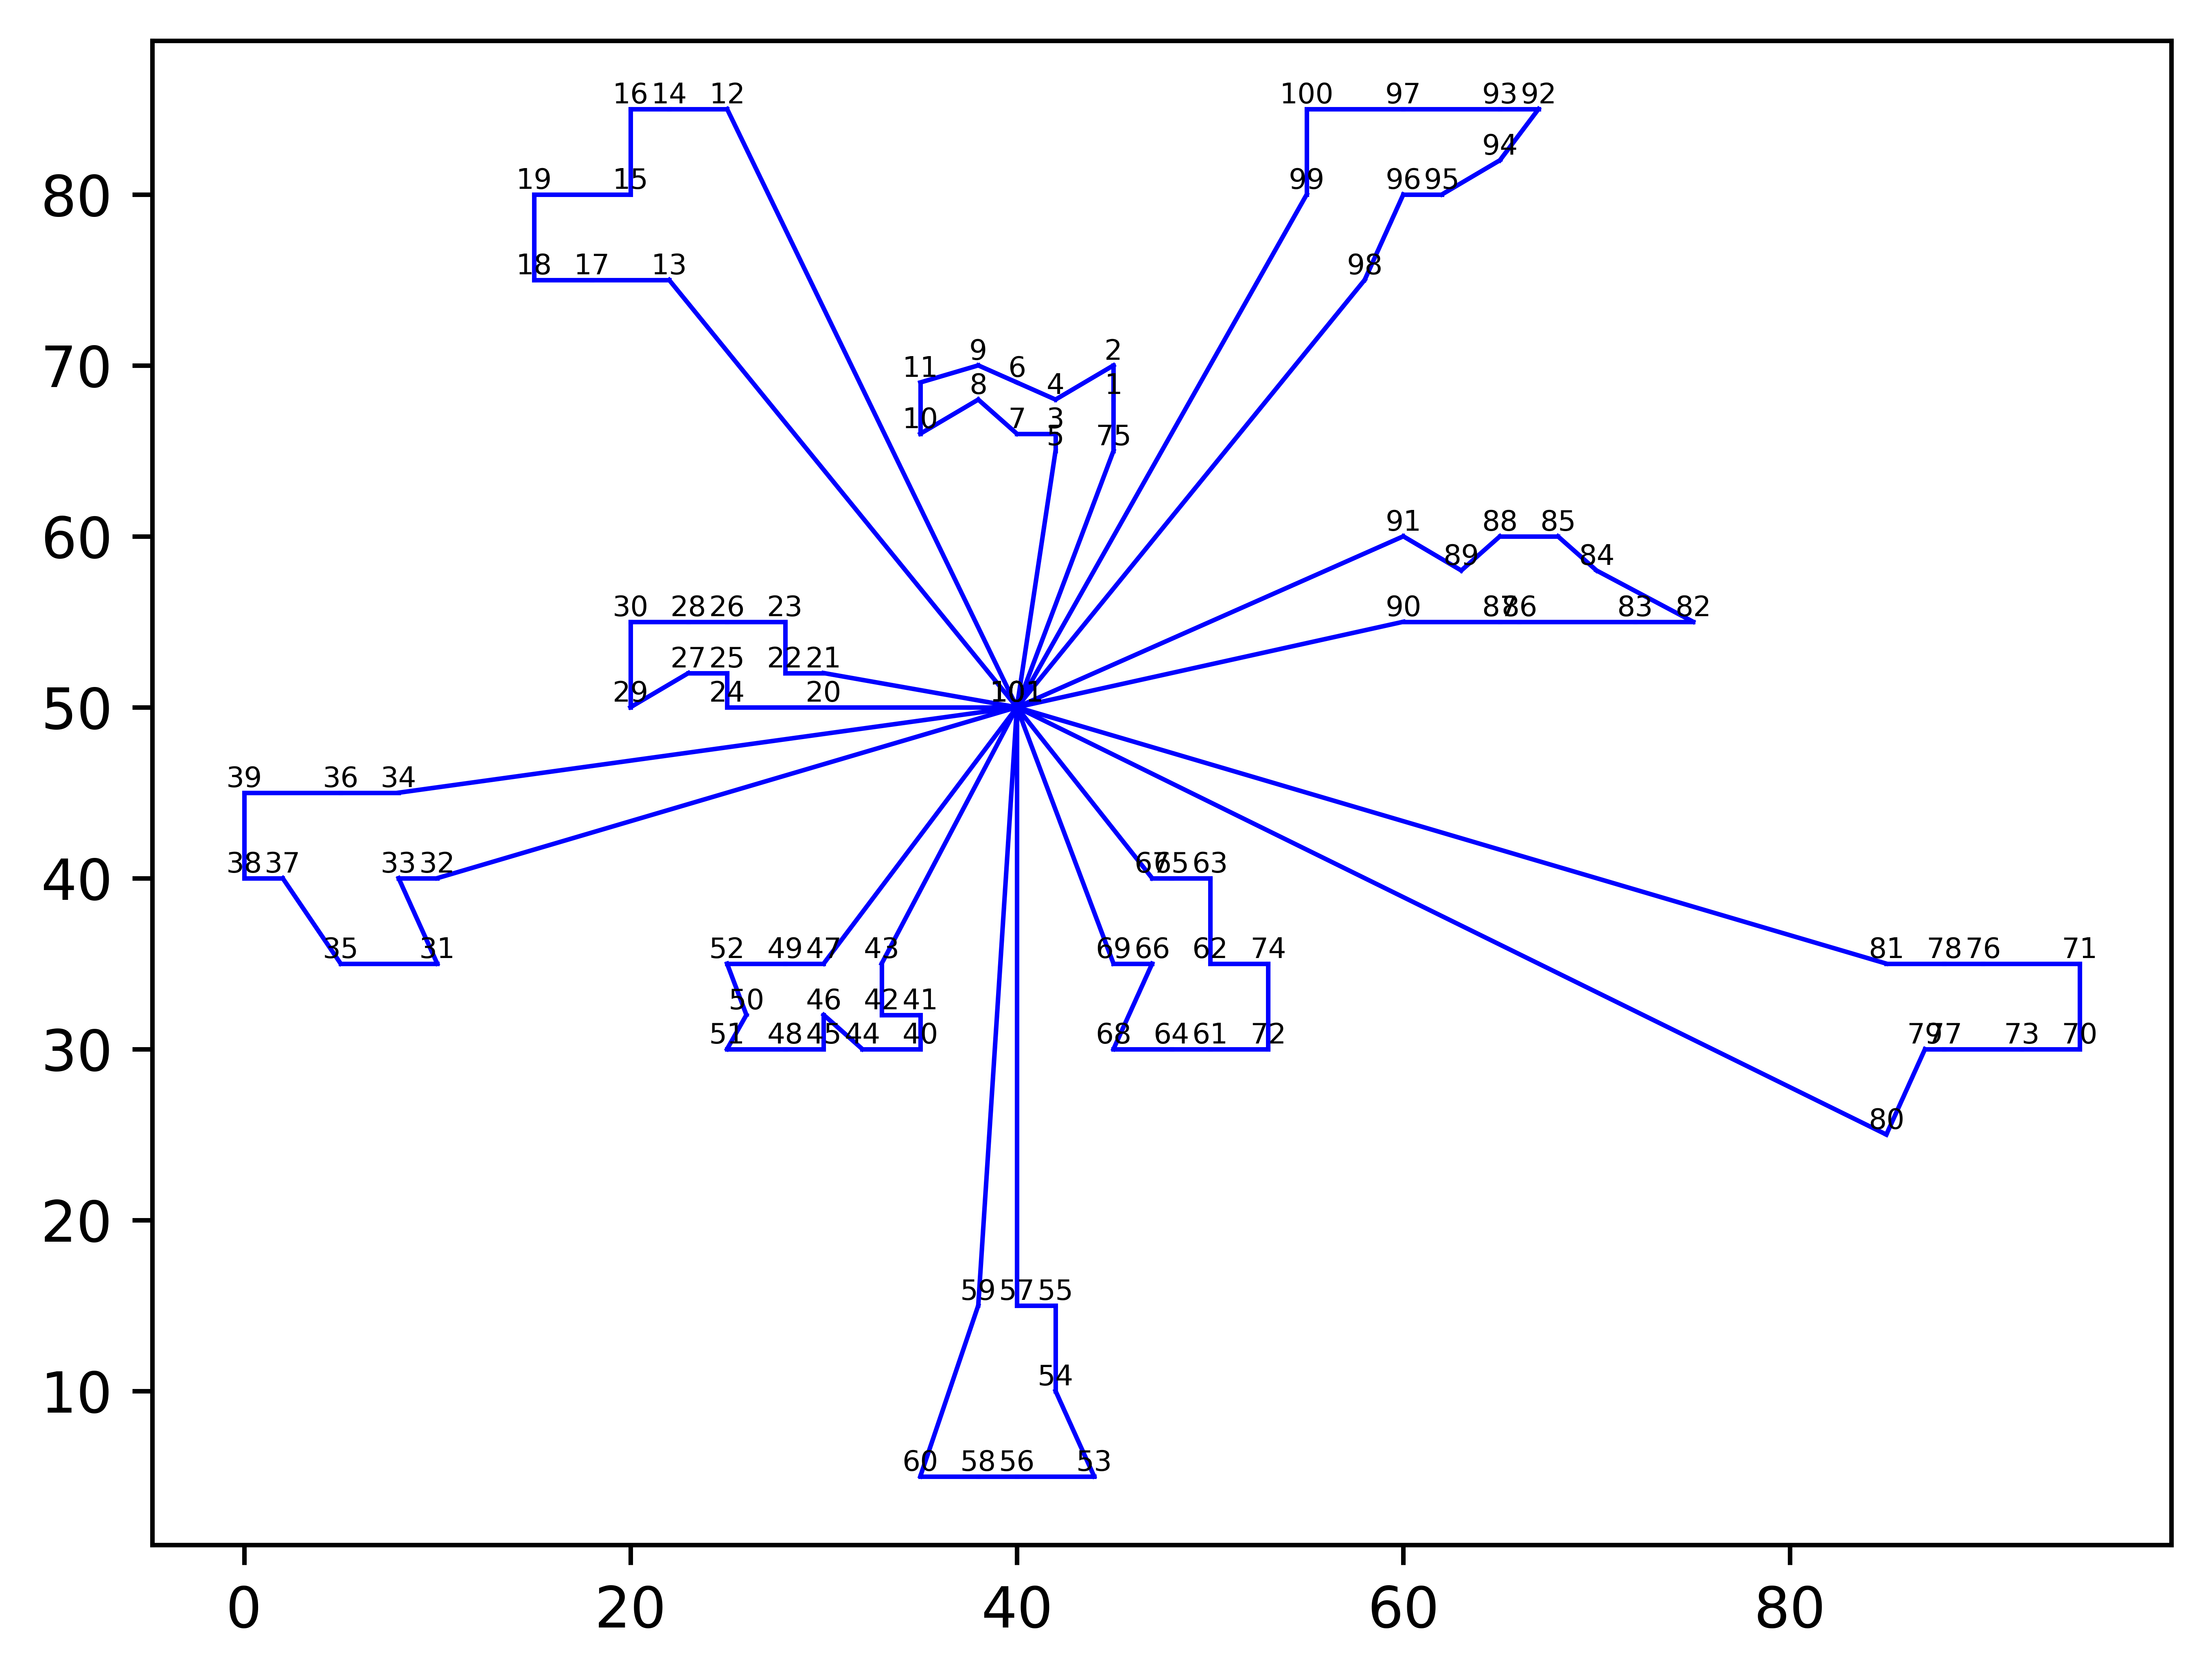

In [16]:
# 路径输出
plt.figure(dpi=1000)
for i in delimiter:
    if i == delimiter[0]: # route第一辆车
        route_for_k = route[0:i,:] 

        # 如果车没使用，直接从出发到返回
        if route_for_k[0,0] == 0 and route_for_k[0,1] == V[-1]:
            print(f'第{route_for_k[0,-1]}辆车的路径为:{0} -> {V[-1]}')
        else: # 如果使用了
            # 先画个从至表
            table = np.zeros((V[-1]+1,V[-1]+1))
            for k in range(route_for_k.shape[0]):
                table[route_for_k[k,0],route_for_k[k,1]] = 1
            # 从至表里面读取信息
            start = 0
            passing = 0
            end = V[-1]
            print(f'第{route_for_k[0,-1]}辆车的路径为:{0}',end='')
            while passing != end:
                temp = table[start,:]
                passing = int(np.argwhere(temp==1))
                plt.plot((x_coord[start],x_coord[passing]),
                         (y_coord[start],y_coord[passing]),c='blue',linewidth=0.8)
                plt.text(x_coord[passing],
                         y_coord[passing], passing ,ha='center', va='bottom', fontsize=5)
                start = passing
                print(f' -> {passing}',end='')
            else:
                print()
    else:
        route_for_k = route[delimiter[delimiter.index(i)-1]:i]
        # print(route_for_k)
        # 如果车没使用，直接从出发到返回
        if route_for_k[0,0] == 0 and route_for_k[0,1] == V[-1]:
            print(f'第{route_for_k[0,-1]}辆车的路径为:{0} -> {V[-1]}')
        else: # 如果使用了
            # 先画个从至表
            table = np.zeros((V[-1]+1,V[-1]+1))
            for k in range(route_for_k.shape[0]):
                table[route_for_k[k,0],route_for_k[k,1]] = 1
            # 从至表里面读取信息
            start = 0
            passing = 0
            end = V[-1]
            print(f'第{route_for_k[0,-1]}辆车的路径为:{0}',end='')

            while passing != end:
                temp = table[start,:]
                passing = int(np.argwhere(temp==1))
                plt.plot((x_coord[start],x_coord[passing]),
                         (y_coord[start],y_coord[passing]),c='blue',linewidth=0.8)
                plt.text(x_coord[passing],
                         y_coord[passing], passing ,ha='center', va='bottom', fontsize=5) 
                start = passing
                print(f' -> {passing}',end='')
            else:
                print()

plt.savefig('route.png')
plt.show()